In [2]:
from modeling import PdfBase, Model, Parameter

In [3]:
from data import DataSet

In [4]:
import numpy as np
from iminuit import Minuit




In [5]:
import matplotlib.pylab as plt
data1 = np.random.normal(loc=20,scale=1, size=1000) # 1st gaussian
data2 = 30*np.random.random(size=1000) # uniform bkg
data3 = np.random.normal(loc=10, scale=10, size=1000) # 2nd gaussian

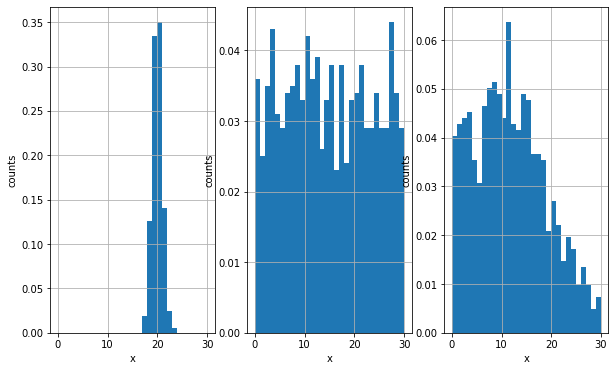

In [6]:
fig, axes = plt.subplots(1,3, figsize=(10,6))
axes[0].grid()
signalPDF, bins, patch = axes[0].hist(data1, bins = 30, range=(0,30), density=True)
axes[0].set_xlabel("x")
axes[0].set_ylabel("counts")

bkgPDF, bins, patch = axes[1].hist(data2, bins = 30, range=(0,30), density=True)
axes[1].grid()
axes[1].set_xlabel("x")
axes[1].set_ylabel("counts")

bkgPDF2, bins, patch = axes[2].hist(data3, bins = 30, range=(0,30), density=True)
axes[2].grid()
axes[2].set_xlabel("x")
axes[2].set_ylabel("counts")

plt.show()
ntotal = 1000
nsig = 0.3 #signal
n1 =  0.4 #First background component.
#third is n2 = 1 - nsig - n1

data = ntotal * (nsig * signalPDF + (1 - nsig) * ( (n1* bkgPDF + (1 - n1)* bkgPDF2)))

[ 27.04450428  24.99265606  28.30673195  31.06080783  23.58820073
  20.97189718  29.05488372  30.87711138  32.23118727  29.8030355
  30.26673195  36.81194614  28.91265606  24.75858017  29.8030355
  30.68895961  21.86227662  31.76227662  59.42820073 118.17929009
 125.82966952  62.19336597  21.78891065  17.8452142   16.71706242
  12.2326071   13.77483476  16.4326071   11.57630355  11.20445532]


Text(0, 0.5, 'density')

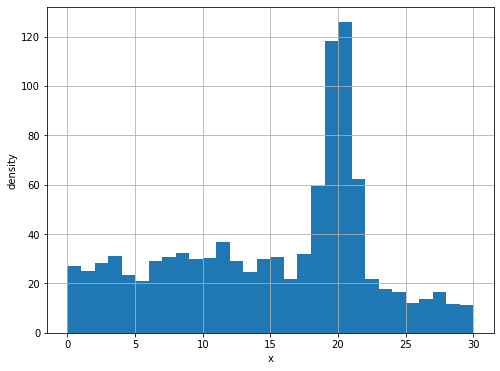

In [7]:
bin_width = np.diff(bins)[0]
bin_centers = bins[:-1] + bin_width/2.

print (data)
fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(bin_centers, data,width=bin_width)
ax.set_xlabel("x")
ax.set_ylabel("density")

In [8]:
#from pdf.pdf import PdfBase

SignalPDF = PdfBase(signalPDF, name="SignalPDF")
AtmosPDF = PdfBase(bkgPDF, name="AtmosPDF")
CorsikaPDF = PdfBase(bkgPDF2, name="CorsikaPDF")

sigfrac = Parameter(value=0.3, limits=(0,1), fixed=False, name="n1")
sigatmos_frac = Parameter(value=0.4, limits=(0,1), fixed=False, name="n2")


#data = ntotal * (nsig * signalPDF + (1 - nsig) * ( (n1* bkgPDF + (1 - n1)* bkgPDF2)))

#model = sigfrac * SignalPDF  + (sigatmos_frac * AtmosPDF + CorsikaPDF - sigatmos_frac * CorsikaPDF) - sigfrac * (sigatmos_frac * AtmosPDF) -  sigfrac * CorsikaPDF + sigfrac * (sigatmos_frac * CorsikaPDF)  

model = sigfrac * SignalPDF  + (1 - sigfrac) * ( sigatmos_frac * AtmosPDF + ( 1 - sigatmos_frac)* CorsikaPDF)

#model = ( 1 - sigatmos_frac) * CorsikaPDF

Parameter n2 already exists in the model, it won't be added again
Parameter n1 already exists in the model, it won't be added again


In [9]:
list(map(np.random.poisson, model))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [10]:
print (model)

 Model: n1*SignalPDF + (1-n1)*(n2*AtmosPDF + (1-n2) * CorsikaPDF)
 Number of pdf: 3
 - SignalPDF
 - AtmosPDF
 - CorsikaPDF
 Number of parameters: 2
 - n1, limits = (0,1),  Is it Fixed? False
 - n2, limits = (0,1),  Is it Fixed? False


In [11]:
print (model.expression)


print (model._pdfs.keys())
print (model._parameters.keys())


print (model[3])

self._parameters['n1'].value*self._pdfs['SignalPDF'][index] + (1 - self._parameters['n1'].value) * (self._parameters['n2'].value*self._pdfs['AtmosPDF'][index] + (1 - self._parameters['n2'].value) * self._pdfs['CorsikaPDF'][index])
odict_keys(['SignalPDF', 'AtmosPDF', 'CorsikaPDF'])
odict_keys(['n1', 'n2'])
0.03106080783353733


Text(0, 0.5, 'density')

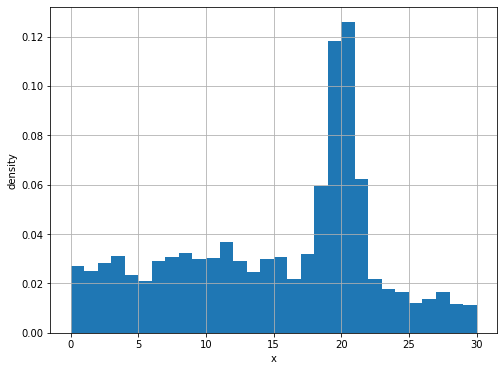

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(bin_centers, model, width=bin_width)
ax.set_xlabel("x")
ax.set_ylabel("density")

In [13]:
dict( model._parameters.items())

{'n1': <modeling.parameter.Parameter at 0x115bc8550>,
 'n2': <modeling.parameter.Parameter at 0x115bc8e10>}

In [14]:
def LLH(pars):
    model._parameters["n1"].value = pars[0]
    model._parameters["n2"].value = pars[1]
    
    values = [d * np.log(ntotal*model[i])-ntotal*model[i] for i, d in enumerate(data)]
      
    return -np.sum(values)

In [15]:
LLH([0.2, 0.1])

-2697.140119558787

In [16]:
kwds = dict()
kwds['errordef']=.5
kwds['print_level'] = 2.
#print list(model._parameters.keys())
names = list(model._parameters.keys())
print (names)
limits =([par.limits for par in list(model._parameters.values())])

print (limits)

['n1', 'n2']
[array([0, 1]), array([0, 1])]


m = Minuit.from_array_func(LLH, (0., 0.) , limit=limits, name=names, **kwds)
m.migrad()

In [18]:
m

In [19]:
from data import DataSet

Text(0, 0.5, 'density')

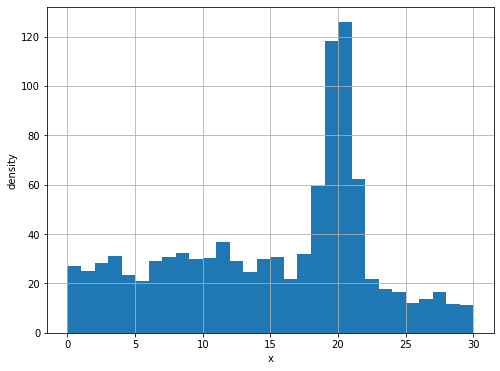

In [20]:
ds = DataSet()
ds.values = data
model._parameters["n1"].value = 0.30
#print (model[:])
ds.residuals(model)


fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(bin_centers, ds.values, width=bin_width)
ax.set_xlabel("x")
ax.set_ylabel("density")

In [22]:
#model._parameters['n1'].value = 0.3
ds.sample(model)
print (ds)


TypeError: '<' not supported between instances of 'list' and 'int'

Text(0, 0.5, 'density')

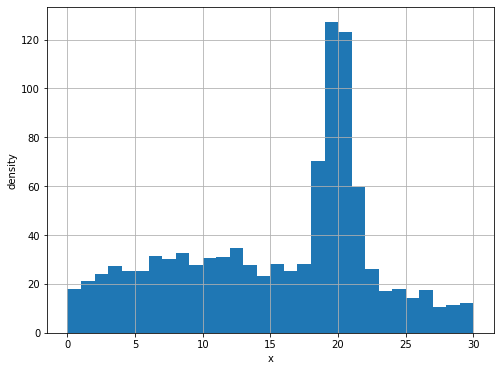

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid()
ax.bar(bin_centers, ds.values, width=bin_width)
ax.set_xlabel("x")
ax.set_ylabel("density")

Text(0, 0.5, 'counts')

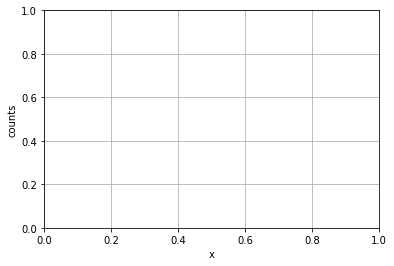

In [22]:
    
#eventlist = np.random.choice(np.arange(0, len(model)), ntotal, p=model[:])


fig, ax = plt.subplots(1, 1)
ax.grid()
ax.set_xlabel("x")
ax.set_ylabel("counts")

    

In [23]:

[p.value = pars[0] for p in iter(model._parameters.values())]



SyntaxError: invalid syntax (<ipython-input-23-c1e83ca9a710>, line 1)

In [78]:
LIKELIHOODS = ["Poisson", "Effective"]
class LikelihoodRatioTest:
    """"""
    
    
    def __init__(self, model, null_model = None, llh_type = "Poisson", data = None, **kwargs):
        self._model = model
        self.llh_type = llh_type
        self._meta_data = kwargs.copy()
        self._data = data
        
        if null_model is not None:
            self._null_model = null_model
            
        
    @property    
    def meta_data(self) -> dict:
        return self._meta_data

    @property
    def data(self) -> DataSet:
        if self._data is not None:
            return self._data
        else:
            raise ValueError("Data has not been loaded yet!")
            
    @data.setter
    def data(self, value: DataSet):
        self._data = value
    

    @property
    def llh_type(self) -> str:
        return self._llh_type
    
    @llh_type.setter
    def llh_type(self, value: str):
        if value in LIKELIHOODS:
            self._llh_type = value
        else:
            print("Likelihood type {} is not implented, available likelihoods are {}".format(value, LIKELIHOODS))
    
    
    
    def evaluate(*pars):
        
        self._model._parameters["n1"].value = pars[0]
        self._model._parameters["n2"].value = pars[1]
    
        values = [d * np.log(ntotal*self._model[i])-ntotal*self._model[i] for i, d in enumerate(data)]
      
        return -np.sum(values)
    
    

In [79]:
dm = LikelihoodRatioTest(model, llh_type = "Poisson")

In [80]:
dm.data = data

In [81]:
len(dm.data)

30